# RANZCR_CLiP Multi-label Classification


### Why Custom Architecture
https://ai.googleblog.com/2019/12/understanding-transfer-learning-for.html

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
from matplotlib.pyplot import figure

In [3]:
import pandas as pd

In [4]:
import glob

In [5]:
import mpld3
mpld3.enable_notebook()

In [6]:
import tensorflow as tf
import tensorflow.keras.layers as layers

### Data loading and exploration

In [7]:
df_train = pd.read_csv("data/train.csv")

In [8]:
df_train_ann = pd.read_csv("data/train_annotations.csv")

In [9]:
df_train.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


In [10]:
len(df_train)

30083

In [11]:
df_train_ann.head()

,StudyInstanceUID,label,data
0,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1487, 1279], [1477, 1168], [1472, 1052], [14..."
1,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1328, 7], [1347, 101], [1383, 193], [1400, 2..."
2,1.2.826.0.1.3680043.8.498.72921907356394389969...,CVC - Borderline,"[[801, 1207], [812, 1112], [823, 1023], [842, ..."
3,1.2.826.0.1.3680043.8.498.11697104485452001927...,CVC - Normal,"[[1366, 961], [1411, 861], [1453, 751], [1508,..."
4,1.2.826.0.1.3680043.8.498.87704688663091069148...,NGT - Normal,"[[1862, 14], [1845, 293], [1801, 869], [1716, ..."


In [12]:
len(df_train_ann)

17999

In [13]:
train_files = glob.glob("data/train/*.jpg")

In [14]:
df_train_ann['data'][0]

'[[1487, 1279], [1477, 1168], [1472, 1052], [1464, 924], [1453, 827], [1443, 755], [1434, 640], [1404, 514], [1387, 497], [1360, 541], [1290, 617], [1228, 696], [1179, 776], [1116, 880], [1065, 963], [1031, 999]]'

In [15]:
def plot_img(df, i, annotate=False, resize_shape=None):
    img = cv2.imread(
        f"data/train/{df['StudyInstanceUID'][i]}.jpg"
    )
    
    if annotate:
        img_wlines = cv2.polylines(
            img, [np.array(eval(df['data'][i]))], 
            isClosed = True, color = (0,255,0),
            thickness = 3,
        )
    figure(num=None, figsize=(8, 6))
    if resize_shape:
        img = cv2.resize(img, resize_shape)
    plt.imshow(img)
    plt.show()
    return img

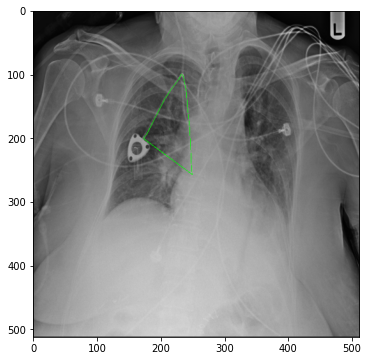

In [16]:
_ = plot_img(df_train_ann, 0, annotate=True, resize_shape=(512, 512))

In [17]:
def get_img_size(fname):
    return cv2.imread(fname).shape

In [18]:
df_train = df_train.sort_values(by='StudyInstanceUID')

In [19]:
y_labels = df_train.iloc[:, 1:-1].values

In [20]:
input_shape = (512, 512, 3)

In [21]:
output_shape = y_labels.shape[-1]

In [22]:
batch_size = 128

In [23]:
df_train.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
747,1.2.826.0.1.3680043.8.498.10000428974990117276...,0,0,0,0,0,0,0,0,0,1,0,04cfbc3d2
773,1.2.826.0.1.3680043.8.498.10001065121843652267...,0,0,0,0,0,0,0,0,0,1,0,176a5edfd
22581,1.2.826.0.1.3680043.8.498.10001175380298620851...,0,0,0,0,0,0,0,0,0,1,0,d57f48a31
19594,1.2.826.0.1.3680043.8.498.10001274045312501651...,0,0,0,0,0,0,0,0,0,1,0,e252d355a
29072,1.2.826.0.1.3680043.8.498.10001645884963994872...,0,0,1,0,0,1,0,0,1,1,0,8849382d0


In [24]:
y_cols = df_train.columns.tolist()[1:-1]

In [25]:
y_cols

['ETT - Abnormal',
 'ETT - Borderline',
 'ETT - Normal',
 'NGT - Abnormal',
 'NGT - Borderline',
 'NGT - Incompletely Imaged',
 'NGT - Normal',
 'CVC - Abnormal',
 'CVC - Borderline',
 'CVC - Normal',
 'Swan Ganz Catheter Present']

In [26]:
train_msk = np.random.rand(len(df_train)) < 0.8

### Setup ds using keras preprocessig

In [27]:
len(np.transpose(y_labels)[0])

30083

In [28]:
import os

In [29]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [30]:
df_train['image'] = df_train['StudyInstanceUID'].apply(lambda x: f"{x}.jpg")

In [31]:
train_ds = datagen.flow_from_dataframe(
    dataframe=df_train[train_msk],
    directory='./data/train',
    seed=1,
    x_col='image',
    y_col=y_cols,
    batch_size=batch_size,
    shuffle=True,
    class_mode='raw',
    target_size=input_shape[:2]
)

Found 24084 validated image filenames.


In [32]:
valid_ds = datagen.flow_from_dataframe(
    dataframe=df_train[~train_msk],
    directory='./data/train',
    seed=1,
    x_col='image',
    y_col=y_cols,
    batch_size=batch_size,
    shuffle=True,
    class_mode='raw',
    target_size=input_shape[:2]
)

Found 5999 validated image filenames.


### Build model and train

In [33]:
def build_model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(
        filters=16, kernel_size=(9,9), strides=4, padding='same'
    )(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2,2), padding='valid')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(
        filters=24, kernel_size=(5,5), strides=1, padding='same'
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2,2), padding='valid')(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(
        filters=32, kernel_size=(5,5), strides=1, padding='same'
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2,2), padding='valid')(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(
        filters=48, kernel_size=(3,3), strides=1, padding='same'
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(4,4), padding='valid')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    out = layers.Dense(output_shape, activation='sigmoid')(x)
    return tf.keras.models.Model(inputs=input_layer, outputs=out)

In [34]:
model = build_model(input_shape)

In [35]:
model.compile(
    optimizer="Adam", 
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(num_thresholds=10)]
)

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      3904      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 16)      64        
_________________________________________________________________
re_lu (ReLU)                 (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 24)        9624  

In [37]:
model.fit(
    train_ds, batch_size=64,
    epochs=50,
    validation_data=valid_ds,
    verbose=1,
)

Epoch 1/50
189/189 [==============================] - 1759s 9s/step - loss: 0.3881 - auc: 0.7831 - val_loss: 0.2802 - val_auc: 0.8533
Epoch 2/50
189/189 [==============================] - 1862s 10s/step - loss: 0.2902 - auc: 0.8460 - val_loss: 0.2874 - val_auc: 0.8798
Epoch 3/50
189/189 [==============================] - 1859s 10s/step - loss: 0.2808 - auc: 0.8578 - val_loss: 0.2968 - val_auc: 0.8810
Epoch 4/50
189/189 [==============================] - 1852s 10s/step - loss: 0.2717 - auc: 0.8660 - val_loss: 0.2977 - val_auc: 0.8815
Epoch 5/50
189/189 [==============================] - 1854s 10s/step - loss: 0.2700 - auc: 0.8696 - val_loss: 0.3153 - val_auc: 0.8746
Epoch 6/50
189/189 [==============================] - 1853s 10s/step - loss: 0.2679 - auc: 0.8721 - val_loss: 0.3005 - val_auc: 0.8795
Epoch 7/50
189/189 [==============================] - 1852s 10s/step - loss: 0.2647 - auc: 0.8751 - val_loss: 0.2705 - val_auc: 0.8655
Epoch 8/50
189/189 [==============================] - 18

In [38]:
model.save('RANZCR-CLiP-custom-v0')

INFO:tensorflow:Assets written to: RANZCR-CLiP-custom-v0/assets


#### Test multi label AUC classification

In [39]:
m = tf.keras.metrics.AUC(num_thresholds=10)

In [40]:
m.reset_states()
m.update_state([[0, 0, 1, 1], [1, 0, 0, 1]], [[0, 0.5, 0.3, 0.9], [0.3, 0.1, 0.25, 0.9]])
m.result().numpy()

0.8125

In [41]:
m.reset_states()
m.update_state([1, 0, 0, 1], [0.3, 0.1, 0.25, 0.9])
m.result().numpy()

0.875

In [42]:
m.reset_states()
m.update_state([0, 0, 1, 1], [0, 0.5, 0.3, 0.9])
m.result().numpy()

0.75